In [11]:
#Data Download directory

dir="/home/advaita/Downloads/data"

In [12]:
#Imports
import numpy as np 
import pandas as pd 

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os 

In [13]:
#Frames


df_stops=pd.read_csv(dir+"/pit_stops.csv")
df_constructor_standing=pd.read_csv(dir+"/constructor_standings.csv")
df_races=pd.read_csv(dir+"/races.csv")

In [14]:
#Merge Frames

commmon_columns_CS_PT=["raceId"]
commmon_columns_CS_PT_RC=["raceId"]

merged_CS_PT=pd.merge(df_stops,df_constructor_standing,on=commmon_columns_CS_PT,how="outer")
merged_CS_PT_RC=pd.merge(merged_CS_PT,df_races,on=commmon_columns_CS_PT_RC,how="outer")



In [15]:
print(merged_CS_PT_RC.describe())

              raceId       driverId           stop            lap  \
count  127112.000000  116628.000000  116628.000000  116628.000000   
mean      924.101194     532.056590       1.799705      25.332390   
std       186.907666     388.151594       1.510880      14.841635   
min         1.000000       1.000000       1.000000       1.000000   
25%       873.000000      18.000000       1.000000      13.000000   
50%       950.000000     816.000000       2.000000      25.000000   
75%      1041.000000     832.000000       2.000000      36.000000   
max      1144.000000     860.000000      70.000000      78.000000   

       milliseconds  constructorStandingsId  constructorId         points  \
count  1.166280e+05           127036.000000  127036.000000  127036.000000   
mean   8.283363e+04            25569.222339      69.295782      92.455713   
std    3.049661e+05             4308.546747      84.177822     136.009386   
min    1.289700e+04                1.000000       1.000000       0.000

In [45]:
#Data cleaning


# nan_count = merged_CS_PT_RC.isna().sum()
# print(nan_count)

# rows_with_nan = merged_CS_PT_RC[merged_CS_PT_RC.isna().any(axis=1)]
# print(rows_with_nan)

df_cleaned=merged_CS_PT_RC.drop(columns=['duration',"round","date","time_y","url","fp1_date","fp1_time","fp3_time","quali_date","fp2_date","fp2_time","fp3_date","quali_time","sprint_date","sprint_time"])
# nan_count = merged_CS_PT_RC.isna().sum()
# print(nan_count)


# Assuming df is your DataFrame

# Print all rows containing NaN values
df_cleaned.dropna(inplace=True)
df_sampled=df_cleaned.sample(n=10900,random_state=42)
df_cleaned.drop(columns=['time_x','positionText','name'],inplace=True,axis=1)
# print(df_cleaned.describe())
print(df_cleaned.head())

       raceId  driverId  stop  lap  milliseconds  constructorStandingsId  \
10462     841     153.0   1.0  1.0       26898.0                 24669.0   
10463     841     153.0   1.0  1.0       26898.0                 24668.0   
10464     841     153.0   1.0  1.0       26898.0                 24667.0   
10465     841     153.0   1.0  1.0       26898.0                 24666.0   
10466     841     153.0   1.0  1.0       26898.0                 24665.0   

       constructorId  points  position  wins  year  circuitId  
10462          131.0     0.0      10.0   0.0  2011          1  
10463            3.0     0.0       9.0   0.0  2011          1  
10464          166.0     0.0       8.0   0.0  2011          1  
10465          205.0     0.0       7.0   0.0  2011          1  
10466           10.0     3.0       6.0   0.0  2011          1  


Visuilazing data

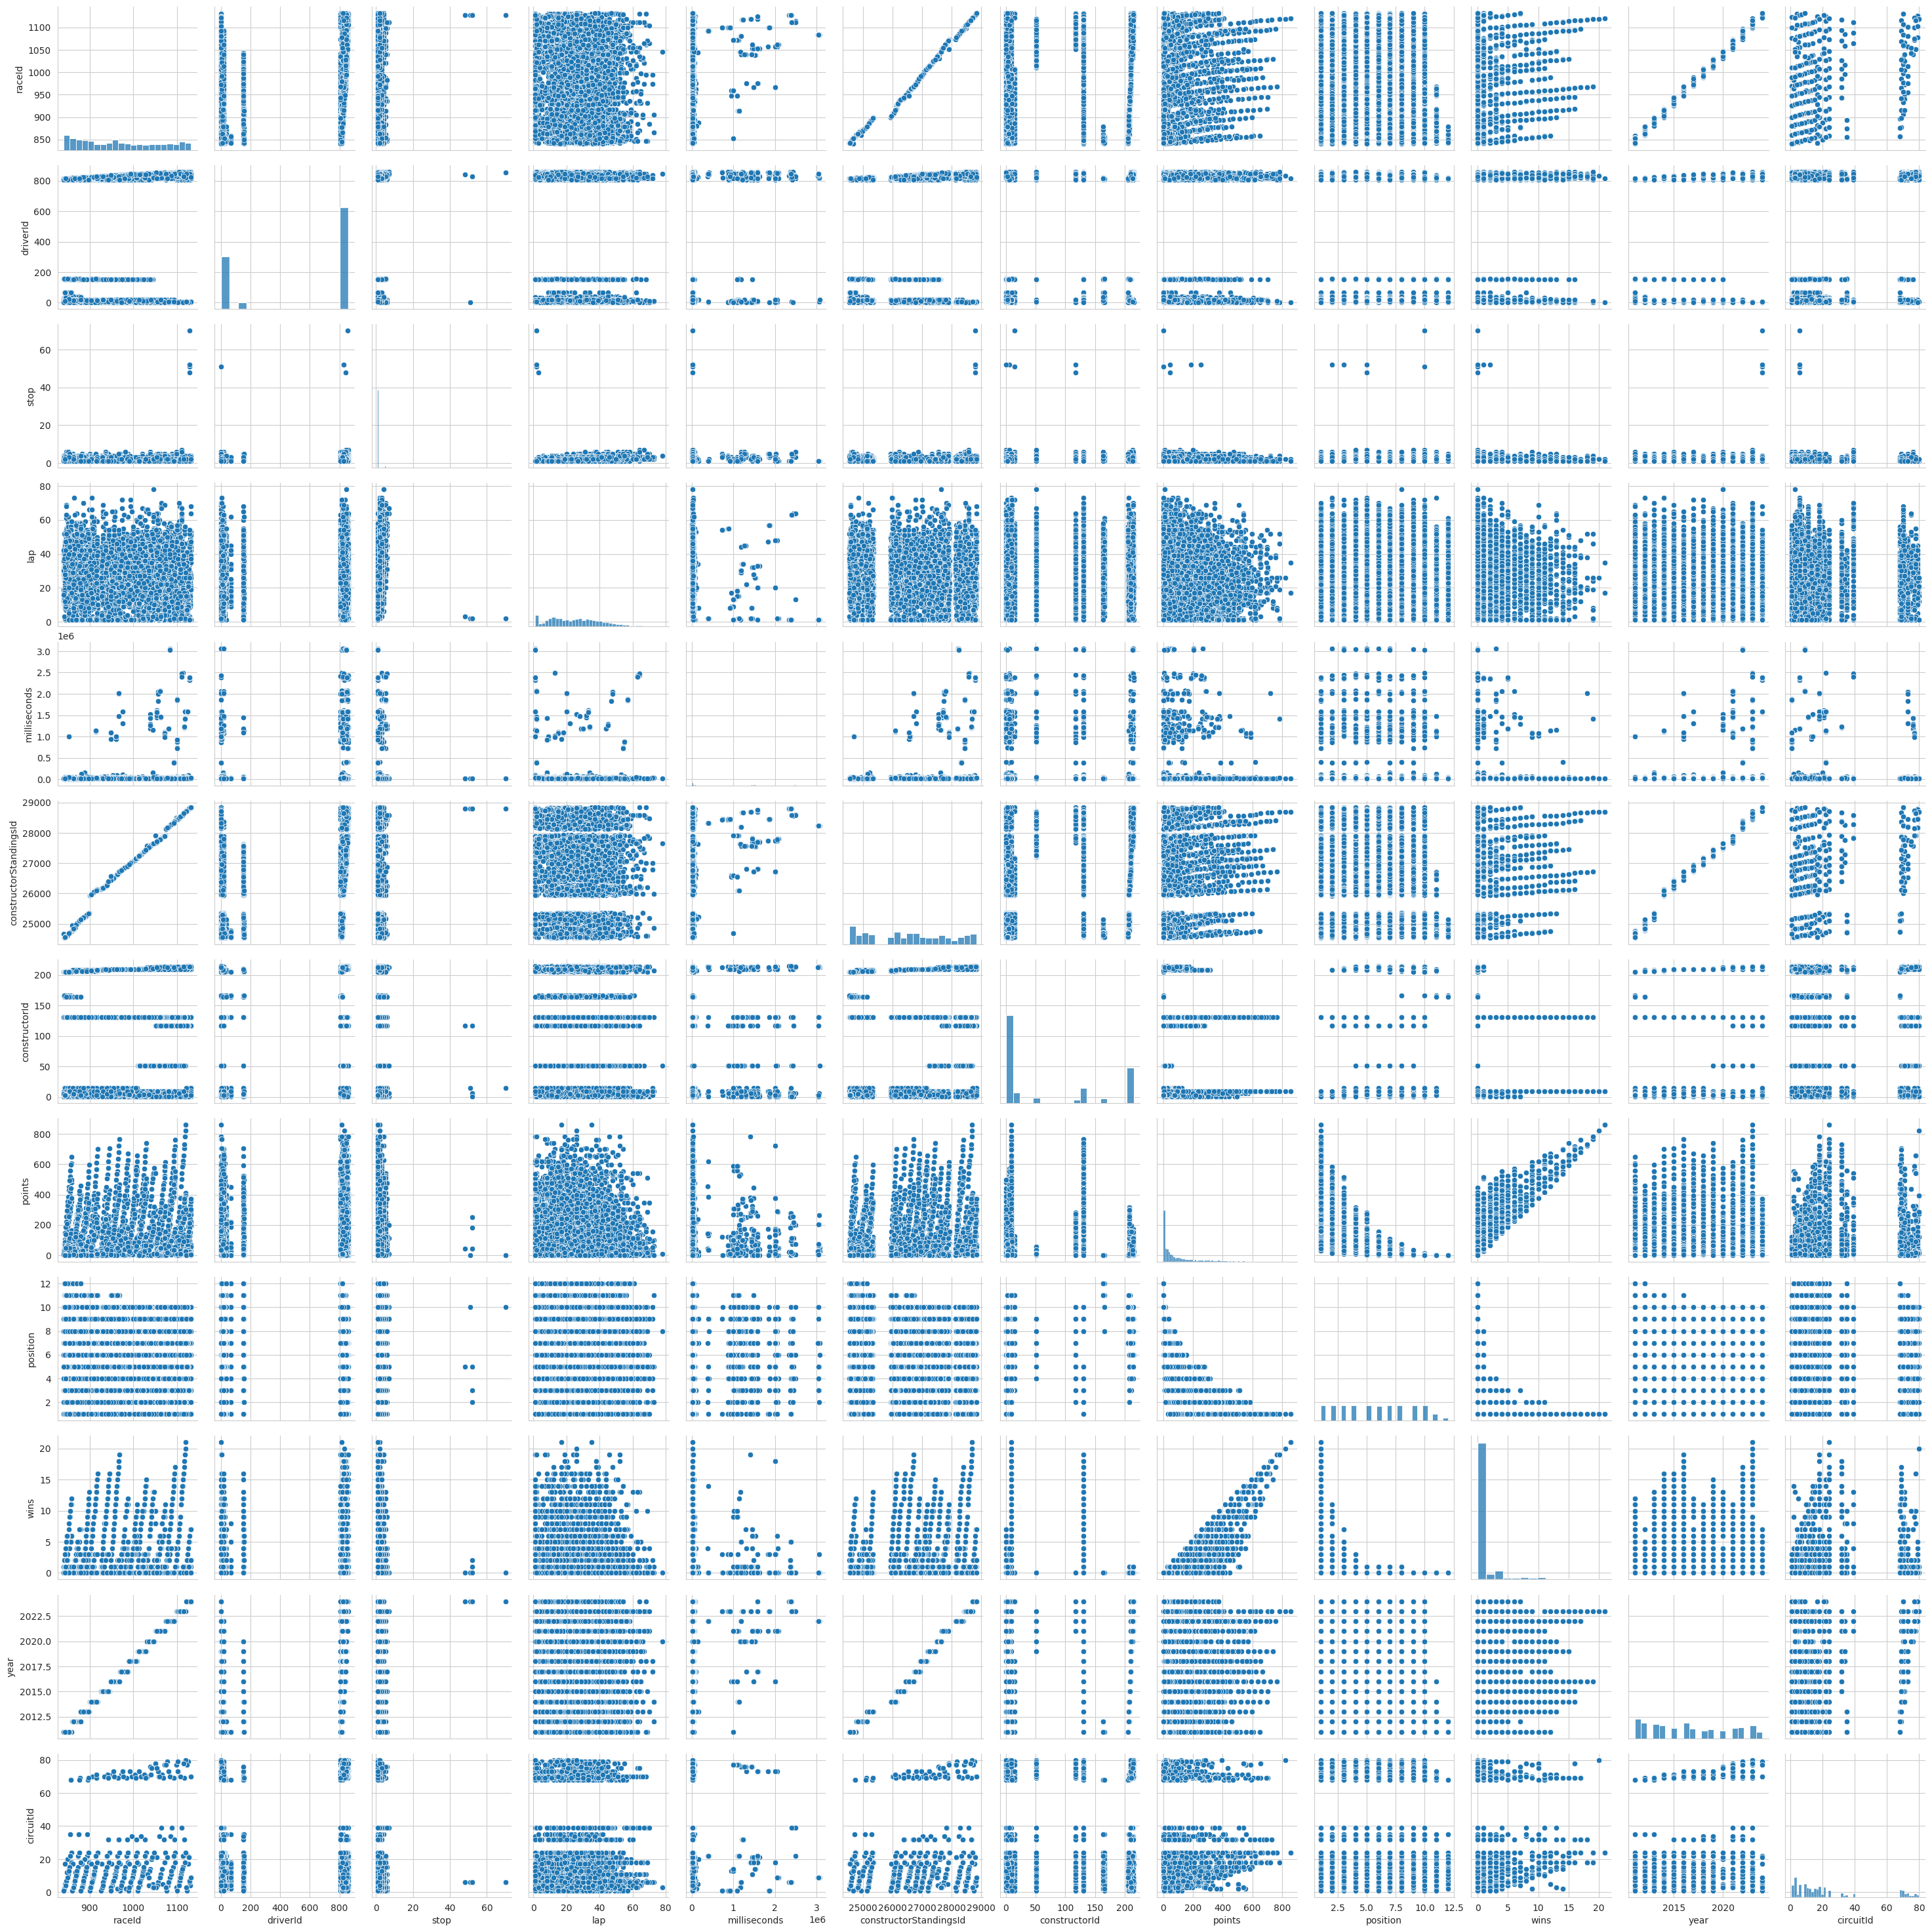

In [46]:
sns.pairplot(df_sampled);

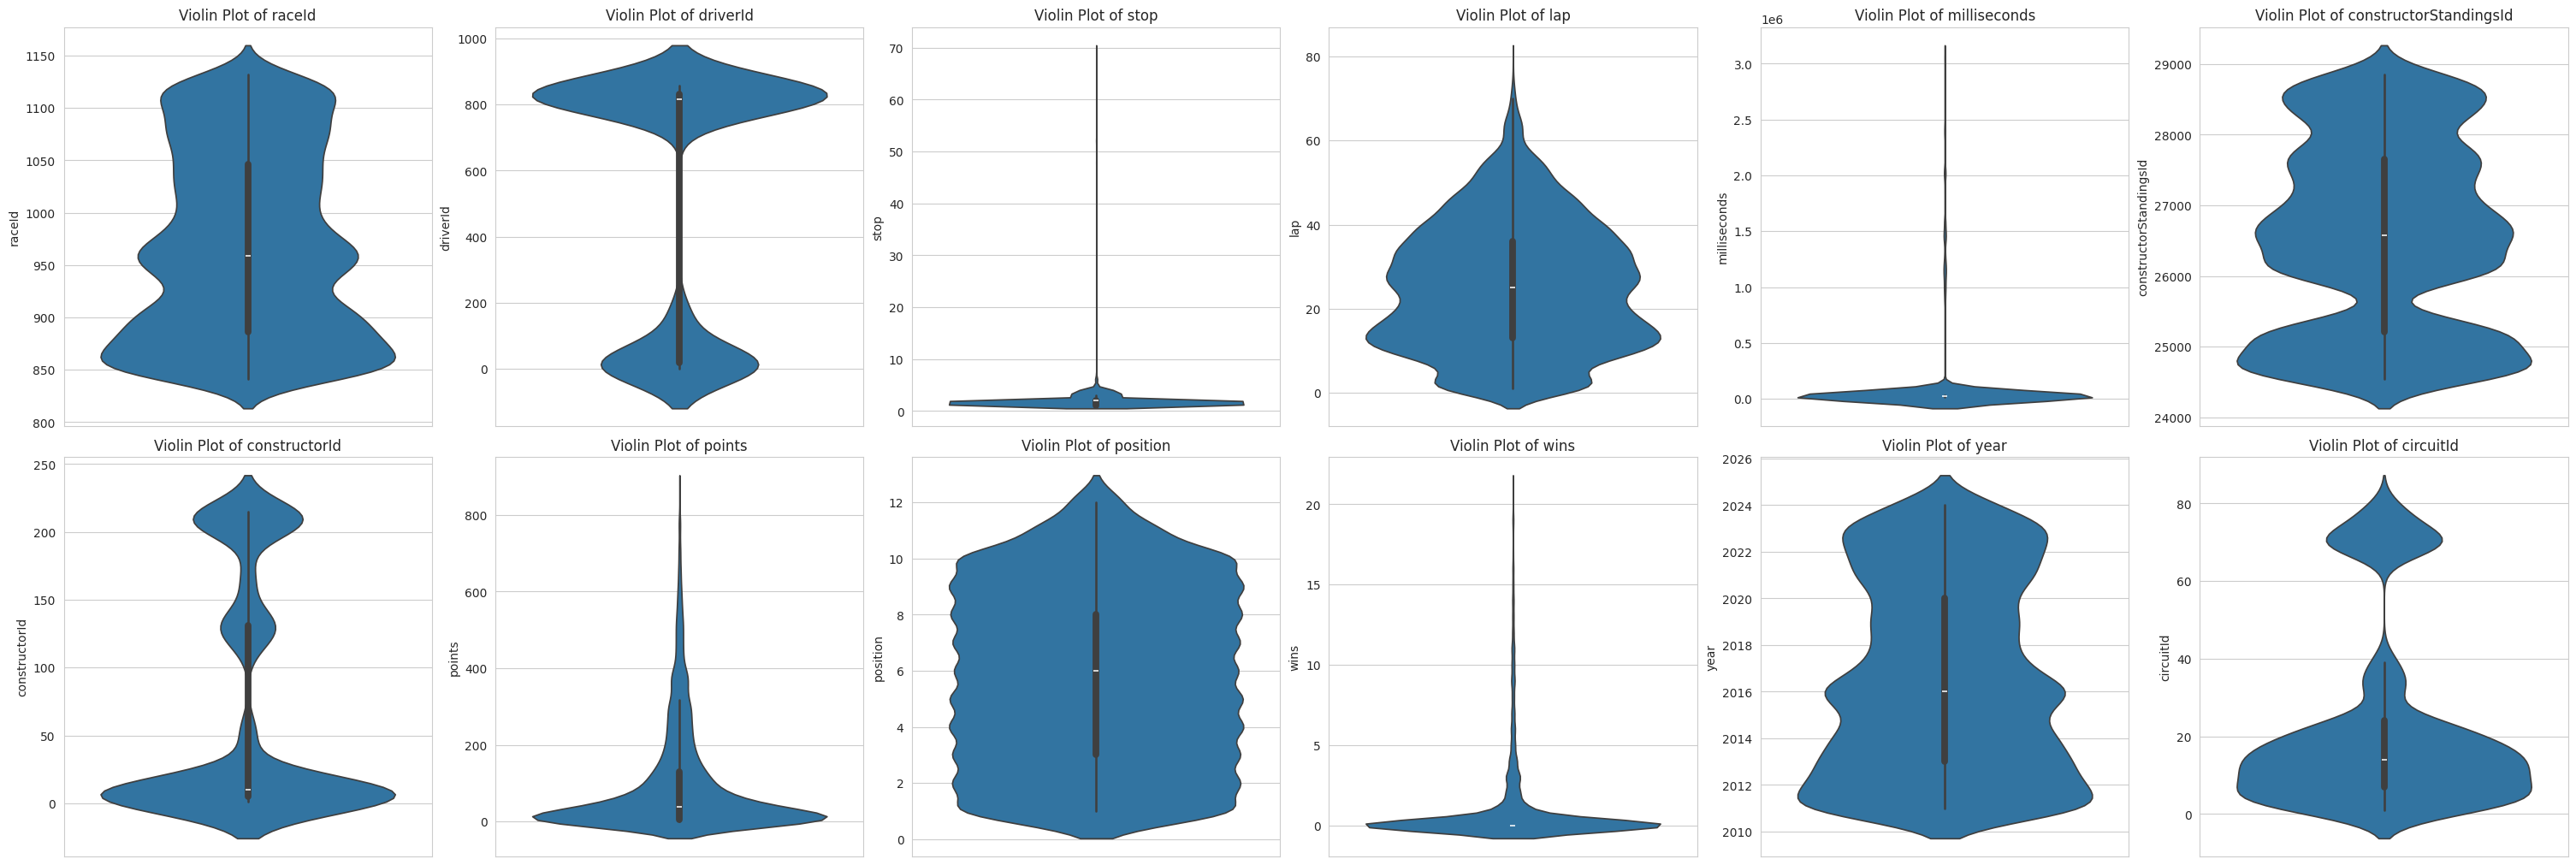

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_plots = len(df_cleaned.columns)

n_cols = math.ceil(num_plots / 2) 
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5), constrained_layout=True)

axes = axes.flatten()

for idx, col in enumerate(df_cleaned.columns):
    sns.violinplot(data=df_sampled, y=col, ax=axes[idx])  
    axes[idx].set_title(f'Violin Plot of {col}')  

if num_plots < len(axes):
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i]) 

plt.show()


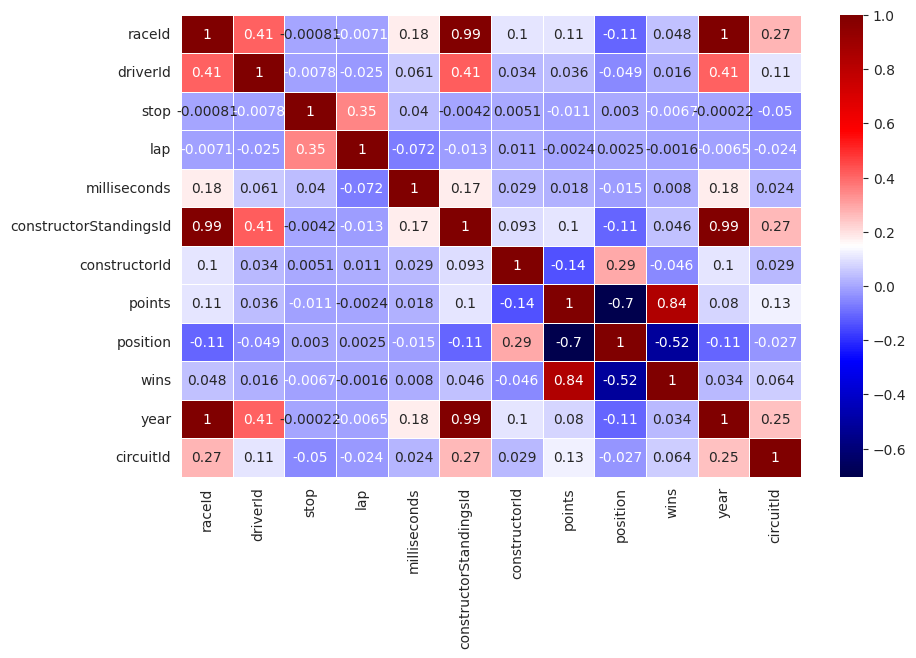

In [51]:

correlation_matrix = df_cleaned.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix,annot=True,cmap='seismic',linewidths=0.5)
plt.show()